# Compare Location Embedding Nearest Neighbors
The goal of this analysis is to quantitatively compare how well different methods encode similarity of buildings in different ways. We will look at the _n_ nearest neighbors (default n = 10) and determine some measure of similarity for those neighbors. The types of similarity we will look at include:
* functionality
* physical distance, i.e. latitude and longitude.

For a baseline, instead of one-hot, use random neighbors.
In this analysis, we only include buildings in the whitelist, "location_twitter_reddit_mention_campus_info.whitelist"

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# we basically want to pretend to be in a different directory
import os
if 'notebooks' not in os.listdir():
    # want to go up one level
    os.chdir('..')
    os.environ['N_SEMESTERS'] = '3'

import pickle
import random
from statistics import mean, stdev
from collections import Counter, defaultdict, OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from haversine import haversine
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cosine
from scipy.stats import sem

from util.util import get_functionalities
from util.prep_location_embeddings import get_location_embeddings, get_multiple_location_embeddings

In [2]:
# load embeddings to test
whitelist = 'data/building_whitelists/location_twitter_reddit_mention_campus_info.whitelist'

notrain_baseline, _ = get_multiple_location_embeddings(
    vector_size=25, window_size=5, epochs=0, skip_gram=True, negative=20, 
    use_whitelist=whitelist)

w2v_base_embedding_list, _ = get_multiple_location_embeddings(
    vector_size=25, window_size=5, epochs=5, skip_gram=True, negative=20, 
    use_whitelist=whitelist)

w2v_hr_embedding_list, _ = get_multiple_location_embeddings(
    vector_size=25, window_size=5, epochs=5, skip_gram=True, negative=20, 
    hour_chunks=True, use_whitelist=whitelist)

twitter_geo_embeddings, _ = get_location_embeddings(
    use_whitelist=whitelist, only_text_embeddings=True,
    text_embedding_methods=['twitter_geo.tfidf_pretrained.glove_twitter'])

reddit_embeddings, _ = get_location_embeddings(
    use_whitelist=whitelist, only_text_embeddings=True,
    text_embedding_methods=['reddit_mention.tfidf_pretrained.glove_twitter'])

campus_info_embeddings, _ = get_location_embeddings(
    use_whitelist=whitelist, only_text_embeddings=True,
    text_embedding_methods=['campus_info.tfidf_pretrained.glove_twitter'])

reddit_concat_embedding_list, _ = get_multiple_location_embeddings(
    vector_size=25, window_size=5, epochs=5, skip_gram=True, negative=20, 
    use_whitelist=whitelist,
    text_embedding_methods=['reddit_mention.tfidf_pretrained.glove_twitter'])

reddit_concat_hr_embedding_list, _ = get_multiple_location_embeddings(
    vector_size=25, window_size=5, epochs=5, skip_gram=True, negative=20,
    use_whitelist=whitelist, hour_chunks=True,
    text_embedding_methods=['reddit_mention.tfidf_pretrained.glove_twitter'])

reddit_retrofit_embeddings, _ = get_location_embeddings(
    use_whitelist=whitelist, only_text_embeddings=True, retrofit_location_graph=True,
    text_embedding_methods=['reddit_mention.tfidf_pretrained.glove_twitter'])

reddit_retrofit_embeddings_weighted, _ = get_location_embeddings(
    use_whitelist=whitelist, only_text_embeddings=True, retrofit_location_graph_weighted=True,
    text_embedding_methods=['reddit_mention.tfidf_pretrained.glove_twitter'])

method_to_emb = {
#     "notrain": notrain_baseline,
#     "W2V-Base": w2v_base_embedding_list,
    "Loc2Vec": w2v_hr_embedding_list,
    "Twitter": twitter_geo_embeddings,
    "Reddit": reddit_embeddings,
    "Campus-Website": campus_info_embeddings,
    "Loc2Vec-Reddit": reddit_concat_hr_embedding_list,
#     "Reddit-Retrofit": reddit_retrofit_embeddings,
    "Reddit-Retrofit": reddit_retrofit_embeddings_weighted,
}

with open(whitelist, "r") as f:
    vocab = f.read().splitlines()
    
# confirm perfect overlap of keys
for i in range(10):
    assert(w2v_base_embedding_list[i].keys() == w2v_hr_embedding_list[i].keys() == twitter_geo_embeddings.keys() ==
          reddit_embeddings.keys() == campus_info_embeddings.keys() == reddit_concat_embedding_list[i].keys() ==
          reddit_retrofit_embeddings.keys() == reddit_retrofit_embeddings_weighted.keys())

In [3]:
STD_ERR_MULTIPLIER = 1.96

## Useful Functions

In [4]:
def get_similarity(embeddings, building_1, building_2):
    return 1 - cosine(embeddings[building_1], embeddings[building_2])

def get_n_nearest_neighbors(embeddings, building, n=10):
    similarity_dict = {}
    for building_2, embedding in embeddings.items():
        if building_2 != building:
            similarity_dict[building_2] = get_similarity(embeddings, building, building_2)
    sorted_neighbors = [item[0] for item in sorted(similarity_dict.items(), key=lambda x: x[1], reverse=True)]
    return sorted_neighbors[:n]

### Functionality Overlap Functions

In [5]:
def functionality_baseline(vocab, both_fn=False):
    building_functionality_map, _, _ = get_functionalities(single=(not both_fn))
    overlaps = []
    for building_1 in vocab:
        overlap = 0
        for building_2 in vocab:
            if building_1 != building_2 and _has_fn_overlap(building_functionality_map, building_1, building_2, both_fn=both_fn):
                overlap += 1
        overlaps.append(overlap / len(vocab) * 100)
    return mean(overlaps), sem(overlaps) * STD_ERR_MULTIPLIER


def functionality_ceiling_at_n(vocab, n=10, both_fn=False):
    building_functionality_map, _, _ = get_functionalities(single=(not both_fn))
    overlaps = []
    for building_1 in vocab:
        b1_overlap = 0
        for building_2 in vocab:
            if _has_fn_overlap(building_functionality_map, building_1, building_2, both_fn=both_fn):
                b1_overlap += 1
        max_overlap = min(b1_overlap - 1, n)
        overlaps.append(max_overlap / n * 100)
    return mean(overlaps), sem(overlaps) * STD_ERR_MULTIPLIER


def _has_fn_overlap(building_functionality_map, building_1, building_2, both_fn=False):
    if both_fn:
        for fn_1 in building_functionality_map[building_1]:
            for fn_2 in building_functionality_map[building_2]:
                if fn_1 == fn_2:
                    return True
        return False
    return building_functionality_map[building_1] == building_functionality_map[building_2]


def _compute_functionality_overlap(embeddings, n=10, both_fn=False):
    building_functionality_map, _, _ = get_functionalities(single=(not both_fn))
    overlaps = {}
    for building_1 in embeddings:
        overlap = 0
        nearest_neighbors = get_n_nearest_neighbors(embeddings, building_1, n=n)
        for building_2 in nearest_neighbors:
            if _has_fn_overlap(building_functionality_map, building_1, building_2, both_fn=both_fn):
                overlap += 1
        overlaps[building_1] = overlap / n * 100
    return mean(list(overlaps.values())), sem(list(overlaps.values())) * STD_ERR_MULTIPLIER, overlaps


def compute_functionality_overlap(embeddings, n=10, both_fn=False):
    if type(embeddings) == list:
        overlaps_all = defaultdict(list)
        mean_overlaps = []
        for emb in embeddings:
            mean_overlap, _, overlaps = _compute_functionality_overlap(emb, n=n, both_fn=both_fn)
            mean_overlaps.append(mean_overlap)
            for building, functionality_overlap in overlaps.items():
                overlaps_all[building].append(functionality_overlap)
        overlaps_seed_averaged = [np.mean(overlaps) for overlaps in overlaps_all.values()]
        return mean(mean_overlaps), sem(overlaps_seed_averaged) * STD_ERR_MULTIPLIER
    return _compute_functionality_overlap(embeddings, n=n, both_fn=both_fn)[:2]

### Average Distance Functions

In [6]:
def _load_lat_lon_map():
    df = pd.read_csv('data/ap_building.csv').drop_duplicates(subset='building')
    return {building: (lat, lon) for building, lon, lat in zip(df['building'], df['GIS.y'], df['GIS.x'])}


def distance_baseline(vocab):
    building_lat_lon = _load_lat_lon_map()
    distances = []
    for building_1 in vocab:
        building_distances = []
        for building_2 in vocab:
            if building_1 != building_2:
                distance = haversine(building_lat_lon[building_1], building_lat_lon[building_2], unit='km')
                building_distances.append(distance)
        distances.append(mean(building_distances))
    return mean(distances), sem(distances) * STD_ERR_MULTIPLIER


def distance_ceiling_at_n(vocab, n=10):
    building_lat_lon = _load_lat_lon_map()
    distances = []
    for building_1 in vocab:
        building_1_distances = []
        for building_2 in vocab:
            if building_1 != building_2:
                distance = haversine(building_lat_lon[building_1], building_lat_lon[building_2], unit='km')
                building_1_distances.append(distance)
        distances.extend(sorted(building_1_distances)[:n])
    return mean(distances), sem(distances) * STD_ERR_MULTIPLIER


def _compute_neighbor_distance(embeddings, building_lat_lon, n=10):
    distances = {}
    for building_1 in embeddings:
        building_distances = []
        nearest_neighbors = get_n_nearest_neighbors(embeddings, building_1, n=n)
        for building_2 in nearest_neighbors:
            distance = haversine(building_lat_lon[building_1], building_lat_lon[building_2], unit='km')
            building_distances.append(distance)
        distances[building_1] = mean(building_distances)
    return mean(list(distances.values())), sem(list(distances.values())) * STD_ERR_MULTIPLIER, distances
    
    
def compute_neighbor_distance(embeddings, n=10):
    building_lat_lon = _load_lat_lon_map()

    if type(embeddings) == list:
        distances_all = defaultdict(list)
        mean_dists = []
        for emb in embeddings:
            mean_dist, _, distances = _compute_neighbor_distance(emb, building_lat_lon, n=n)
            for building, distance in distances.items():
                distances_all[building].append(distance)
            mean_dists.append(mean_dist)
        distances_seed_averaged = [np.mean(distances) for distances in distances_all.values()]
        return mean(mean_dists), sem(distances_seed_averaged) * STD_ERR_MULTIPLIER
    return _compute_neighbor_distance(embeddings, building_lat_lon, n=n)[:2]


def get_individual_distance_results(embeddings, n=10):
    if type(embeddings) == list:
        distance_lists = defaultdict(list)
        results = []
        for emb in embeddings:
            results.append(get_individual_distance_results(emb, n=n))
        for result in results:
            for building, distance in result.items():
                distance_lists[building].append(distance)
        return {building: mean(dist_list) for building, dist_list in distance_lists.items()}
    building_lat_lon = _load_lat_lon_map()
    distances = {}
    for building_1 in embeddings:
        building_distances = []
        nearest_neighbors = get_n_nearest_neighbors(embeddings, building_1, n=n)
        for building_2 in nearest_neighbors:
            distance = haversine(building_lat_lon[building_1], building_lat_lon[building_2], unit='km')
            building_distances.append(distance)
        distances[building_1] = mean(building_distances)
    return distances

## Results

In [27]:
# note: this takes about 5 minutes to run
# build DataFrame/Graph
# cols: method, n, func (both fn), dist
results = []
# k values from Ye et al. --> for our use case, possibly consider removing 100 and adding 5, 25
n_vals = [1, 5, 10, 25, 50, 100]

# add baselines
for n_val in n_vals:
    dist_ceil = distance_ceiling_at_n(vocab, n=n_val)
    func_ceil = functionality_ceiling_at_n(vocab, n=n_val)
    results.append(("Oracle", n_val, func_ceil[0], func_ceil[1], dist_ceil[0], dist_ceil[1]))

fn_baseline = functionality_baseline(vocab, both_fn=True)
dist_baseline = distance_baseline(vocab)
for n in n_vals:
    results.append(("Overall Avg", n, fn_baseline[0], fn_baseline[1], dist_baseline[0], dist_baseline[1]))

for method, emb in method_to_emb.items():
    for n in n_vals:
        fu, fustdev = compute_functionality_overlap(emb, both_fn=True, n=n)
        di, distdev = compute_neighbor_distance(emb, n=n)
        results.append((method, n, fu, fustdev, di, distdev))

In [28]:
results_df = pd.DataFrame(results, columns=["method", "n", "func_overlap", "func_overlap_stdev", "dist", "dist_stdev"])

In [29]:
results_df = results_df[results_df["method"] != "notrain"]

In [30]:
results_df["method"] = results_df["method"].apply(lambda x: "Reddit-Retrofit" if x == "Reddit-Retrofit-W" else x)

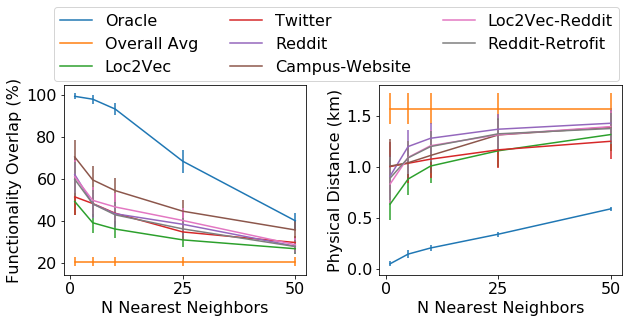

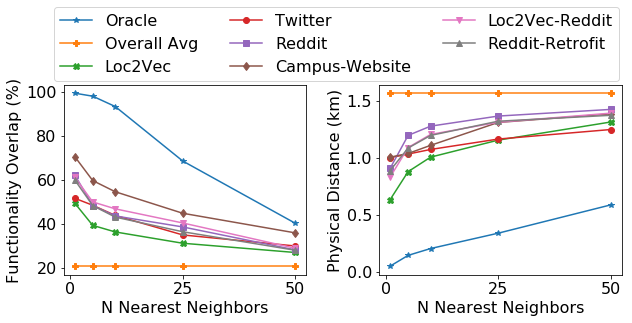

In [32]:
from matplotlib import container

def plot_sll_results(df, include_100=False, errorbars=False):
    matplotlib.rcParams.update({"font.size": 16})
    # filter out results for 100 if include_100 is false
    if not include_100:
        df = df[df["n"] != 100]
    chosen_markers = ["*", "P", "X", "o", "s", "d", "v", "^", ">"]
    palette = sns.color_palette()[:len(chosen_markers)]
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3.5))

#     print(df)
    for marker, method, color in zip(chosen_markers, df["method"].unique(), palette):
        sub = df[df["method"] == method]
        if errorbars:
            axs[0].errorbar(x=sub["n"], y=sub["func_overlap"], yerr=sub["func_overlap_stdev"], label=method)
            axs[1].errorbar(x=sub["n"], y=sub["dist"], yerr=sub["dist_stdev"], label=method)
        else:
            axs[0].plot(sub["n"], sub["func_overlap"], label=method, marker=marker)
            axs[1].plot(sub["n"], sub["dist"], label=method, marker=marker)

    # fix legend: we remove "method" from the labels list, and 
    handles, labels = axs[0].get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    axs[0].legend(handles=handles, labels=labels, ncol=3, loc=2, bbox_to_anchor=(-.075, 1.45))

    # label y axes
    axs[0].set_ylabel("Functionality Overlap (%)")
    axs[1].set_ylabel("Physical Distance (km)")

    # label x axes
    axs[0].set_xlabel("N Nearest Neighbors")
    axs[1].set_xlabel("N Nearest Neighbors")

    # set x ticks
    tick_positions = [0, 25, 50, 75, 100] if include_100 else [0, 25, 50]
    axs[0].set_xticks(tick_positions)
    axs[1].set_xticks(tick_positions)
    
    # note: some hacks in here to get font size large enough without overlaps
    plt.subplots_adjust(wspace=.3)
    plt.show()


# plot 50 with and without error bars
plot_sll_results(results_df, include_100=False, errorbars=True)
plot_sll_results(results_df, include_100=False, errorbars=False)

In [19]:
# also show results at n = 10 as was done previously
results_df[results_df["n"] == 10]

method   n  func_overlap  func_overlap_stdev      dist  \
2       Overall Avg  10     20.672635            2.068296  1.566551   
8           Loc2Vec  10     36.212121            4.255961  1.005748   
14          Twitter  10     43.712121            4.958726  1.073040   
20           Reddit  10     43.484848            6.323624  1.277457   
26   Campus-Website  10     54.469697            5.910804  1.109100   
32   Loc2Vec-Reddit  10     46.704545            6.442836  1.204764   
38  Reddit-Retrofit  10     42.954545            5.968495  1.196314   

    dist_stdev  
2     0.151758  
8     0.163405  
14    0.189286  
20    0.144944  
26    0.173383  
32    0.149331  
38    0.155373

### See what the "best" locations are

In [50]:
df = None
for method, emb in method_to_emb.items():
    res = pd.DataFrame.from_dict(get_individual_distance_results(emb, 5), orient="index", columns=[method])
    res.index = res.index.rename("location_name")
    if df is None:
        df = res
    else:
        df = pd.merge(df, res, on="location_name")

In [60]:
building_lat_lon = _load_lat_lon_map()


get_n_nearest_neighbors(method_to_emb["W2V-Base"][1], "DC", 5)

['NCCOMM', 'BEYSTER', 'DOW', 'CHRY', 'GGBL']